In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
plt.rc('text', usetex=True)
plt.rc('font', family='Serif')

import matplotlib as mpl 
mpl.rcParams['figure.figsize'] = [9, 9]
mpl.rcParams['font.size'] = 27

mpl.rcParams['savefig.dpi'] = 150 
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'

mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

mpl.rcParams['xtick.major.size'] = 10 
mpl.rcParams['xtick.minor.size'] = 5 

mpl.rcParams['ytick.major.size'] = 10 
mpl.rcParams['ytick.minor.size'] = 5 

mpl.rcParams['xtick.labelsize'] = 23
mpl.rcParams['ytick.labelsize'] = 23

In [2]:
GC_name = 'NGC3201'
data_path = os.getcwd()
fidanka = pd.read_csv('fiducial_lines.csv')

In [3]:
df = pd.read_csv(GC_name + '_fitstars.dat')

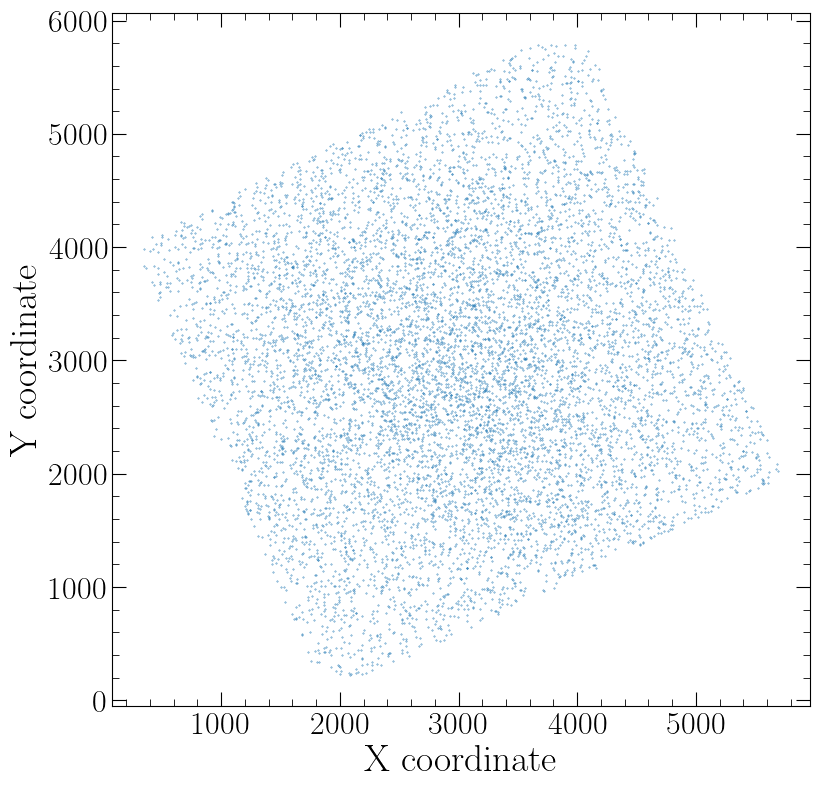

In [4]:
Coord = df[['x','y']].values
plt.scatter(Coord[:,0],Coord[:,1],s=0.1)
plt.xlabel("X coordinate")
plt.ylabel('Y coordinate');

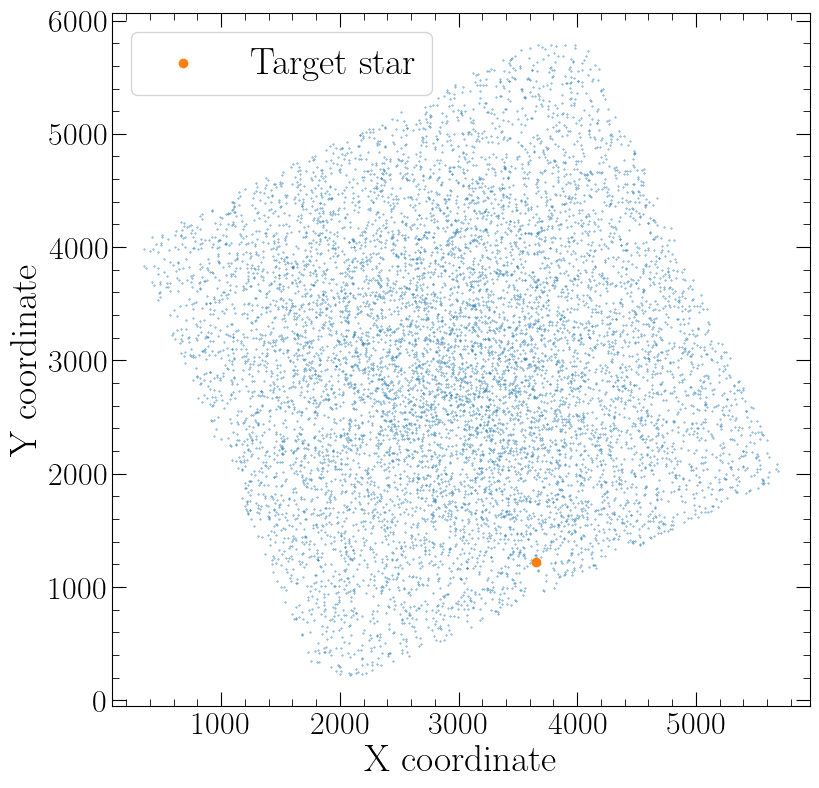

In [5]:
idx = 1500
plt.scatter(Coord[:,0],Coord[:,1],s=0.1)
plt.scatter(df.iloc[idx]['x'], df.iloc[idx]['y'],label='Target star')
plt.xlabel("X coordinate")
plt.ylabel('Y coordinate')
plt.legend();

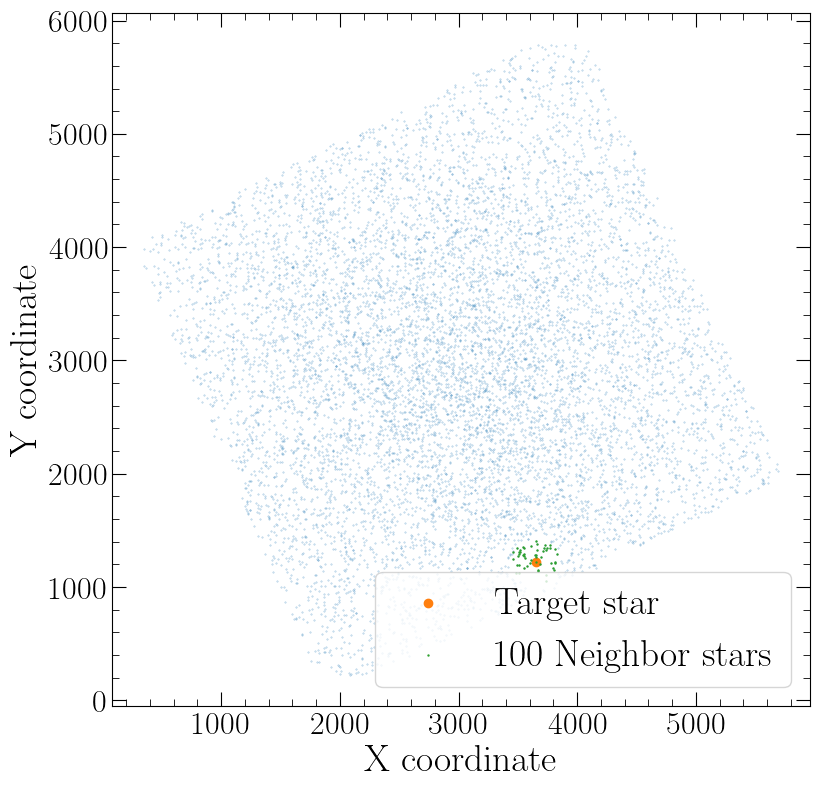

In [6]:
neighbors = df.iloc[np.argpartition(np.sum(np.square(df.iloc[idx][['x','y']].values - Coord),axis=1),50)[:50]]
plt.scatter(Coord[:,0],Coord[:,1],s=0.1,alpha=0.5)
plt.scatter(df.iloc[idx]['x'], df.iloc[idx]['y'],label='Target star')
plt.scatter(neighbors['x'], neighbors['y'],s=0.5,label='100 Neighbor stars')
plt.xlabel("X coordinate")
plt.ylabel('Y coordinate')
plt.legend();

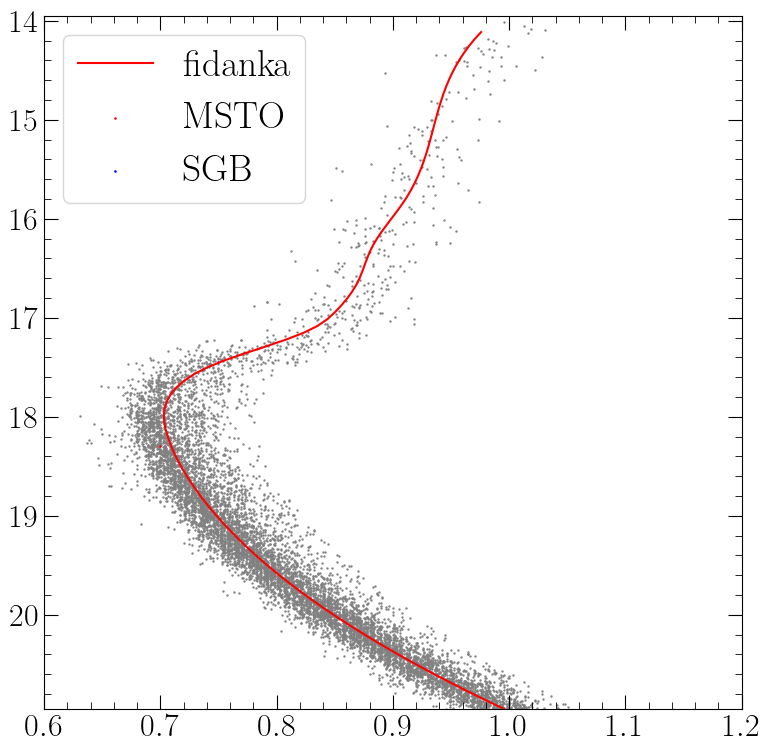

In [7]:
V_MSTO = 18.3
VI_MSTO = 0.70
V_SGB = 17.45
VI_SGB = 0.75
plt.plot(fidanka['vi'],fidanka['v'],c='r',label='fidanka')
plt.scatter(df['vi'],df['v'],s=0.5,alpha=1,c='grey')
plt.scatter(VI_MSTO,V_MSTO,s=0.7,c='r',label='MSTO')
plt.scatter(VI_SGB,V_SGB,s=0.7,c='b',label='SGB')
plt.legend()
plt.ylim(V_SGB+3.5,V_SGB-3.5)
plt.xlim(0.6,1.2);

In [14]:
#determine theta
#Table From Bedin, L. R., et al 2005
from scipy.interpolate import interp1d
E_BV_list = np.array([0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,1.0])
A_F606W_list = np.array([0.0,0.14,0.279,0.419,0.558,0.595,0.834,0.972,1.110,1.248,1.385,1.522,1.658,1.794,1.930,2.066,2.202,2.741])
A_F814W_list = np.array([0.0,0.092,0.184,0.276,0.367,0.459,0.550,0.641,0.732,0.823,0.913,1.004,1.094,1.184,1.274,1.364,1.454,1.811])
ff_606 = interp1d(E_BV_list, A_F606W_list)
ff_814 = interp1d(E_BV_list, A_F814W_list)
E_BV = 0.24
A_F814W = ff_814(E_BV)
A_F606W = ff_606(E_BV)
theta = np.arctan(A_F814W/(A_F606W - A_F814W))
theta

1.2487734412503027

In [19]:
R_mat = np.array([[np.cos(-theta), -np.sin(-theta)],[np.sin(-theta),np.cos(-theta)]])
Obs_Rot = np.matmul(R_mat,(df[['vi','v']].values - np.array([VI_SGB,V_SGB])).T)
fidanka_Rot = np.matmul(R_mat,(fidanka[['vi','v']].values - np.array([VI_SGB,V_SGB])).T)
df['xprime'] = Obs_Rot[0]
df['yprime'] = Obs_Rot[1]
neighbors = df.iloc[np.argpartition(np.sum(np.square(df.iloc[idx][['x','y']].values - Coord),axis=1),50)[:50]]

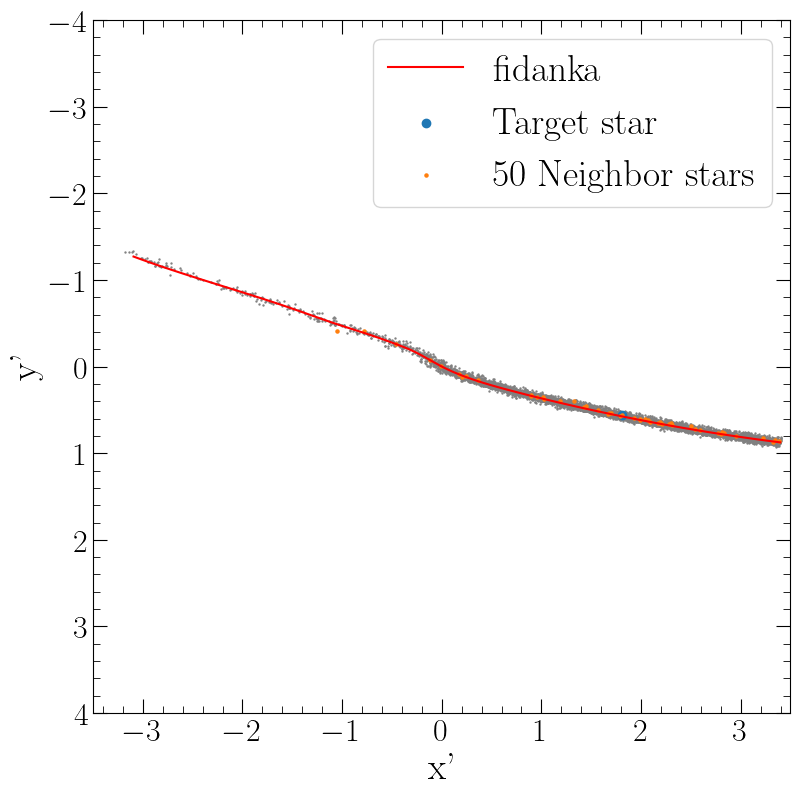

In [20]:
plt.scatter(df['xprime'],df['yprime'],s=0.5,alpha=1,c='grey')
plt.plot(fidanka_Rot[0],fidanka_Rot[1],c='r',label='fidanka')
plt.scatter(df.iloc[idx]['xprime'], df.iloc[idx]['yprime'],label='Target star')
plt.scatter(neighbors['xprime'], neighbors['yprime'],s=5,label='50 Neighbor stars')
plt.xlim(-3.5,3.5)
plt.ylim(4,-4)
plt.xlabel('x\'')
plt.ylabel('y\'')
plt.legend();

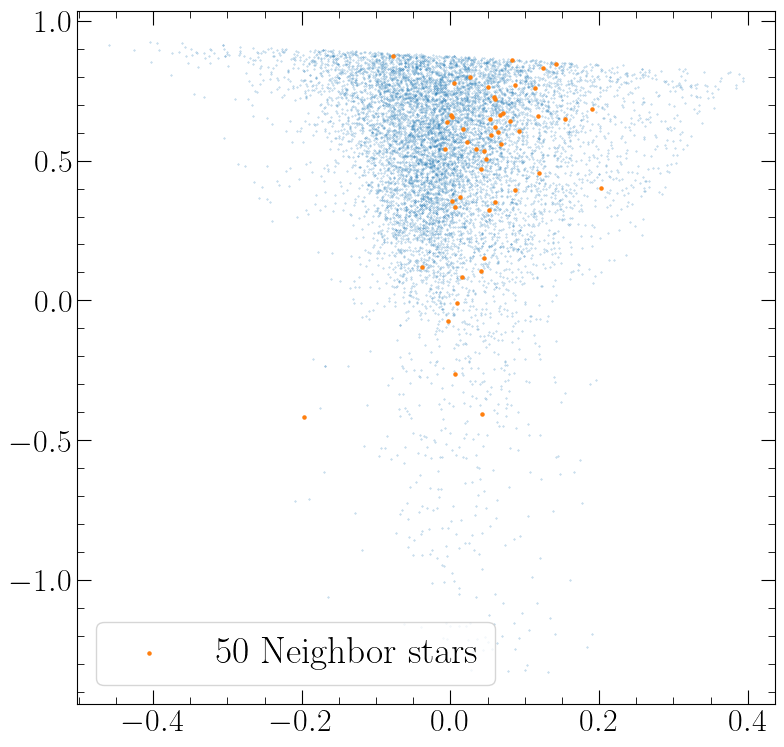

In [21]:
from scipy.interpolate import CubicSpline
ff = CubicSpline(fidanka_Rot[1],fidanka_Rot[0],extrapolate=True)
plt.scatter(df['xprime'] - ff(df['yprime']),df['yprime'],s=0.1,alpha=0.5)
plt.scatter(neighbors['xprime'] - ff(neighbors['yprime']), neighbors['yprime'],s=5,label='50 Neighbor stars')
plt.legend();

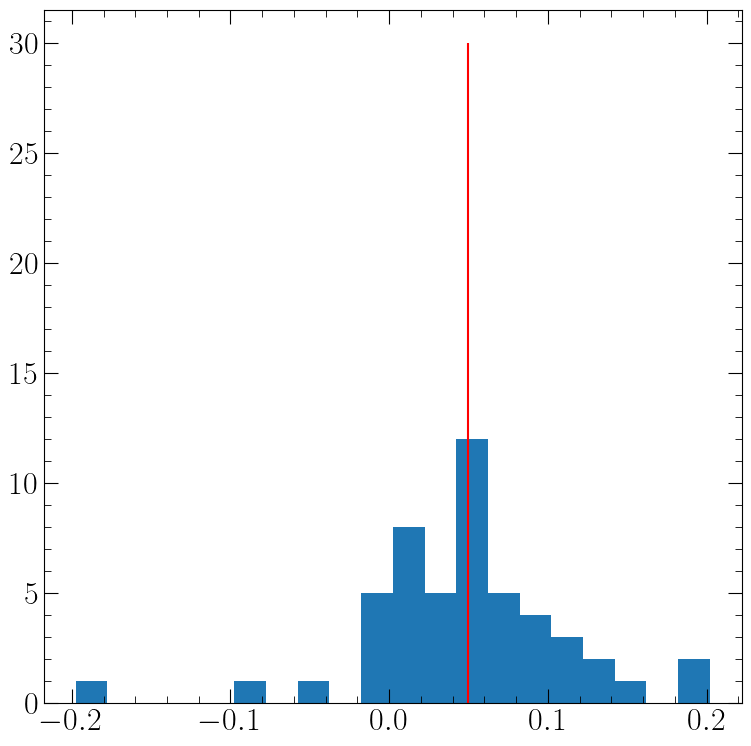

In [22]:
plt.hist(neighbors['xprime'] - ff(neighbors['yprime']),bins=20)
plt.vlines(np.median(neighbors['xprime'] - ff(neighbors['yprime'])),0,30,'r')

In [23]:
idxs = range(len(df))
delta_x = np.zeros(len(df))
start_time = time.time()
for idx in idxs:
    neighbors = df.iloc[np.argpartition(np.sum(np.square(df.iloc[idx][['x','y']].values - Coord),axis=1),50)[:50]]
    delta_x[idx] = np.median(neighbors['xprime'] - ff(neighbors['yprime']))
print("--- %s seconds ---" % (time.time() - start_time))

--- 3.6448678970336914 seconds ---


Text(0, 0.5, "y'")

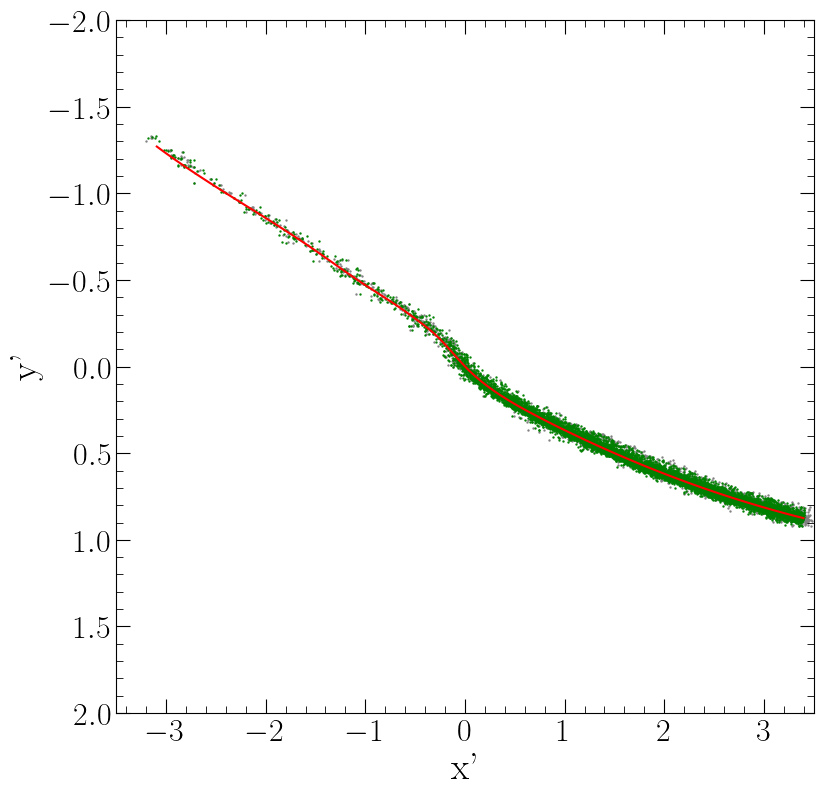

In [24]:
plt.scatter(df['xprime'] - delta_x, df['yprime'],s=0.5,alpha=1,c='grey')
plt.scatter(df['xprime'], df['yprime'],s=0.5,alpha=1,c='g')
plt.plot(fidanka_Rot[0],fidanka_Rot[1],c='r',label='fidanka')
plt.xlim(-3.5,3.5)
plt.ylim(2,-2)
plt.xlabel('x\'')
plt.ylabel('y\'')

In [25]:
Obs_Rot_CR = df[['xprime','yprime']].values.T
Obs_Rot_CR[0] -= delta_x.T

In [26]:
obs_CR = np.matmul(np.linalg.inv(R_mat),Obs_Rot_CR) + np.array([[VI_SGB,V_SGB]]).T

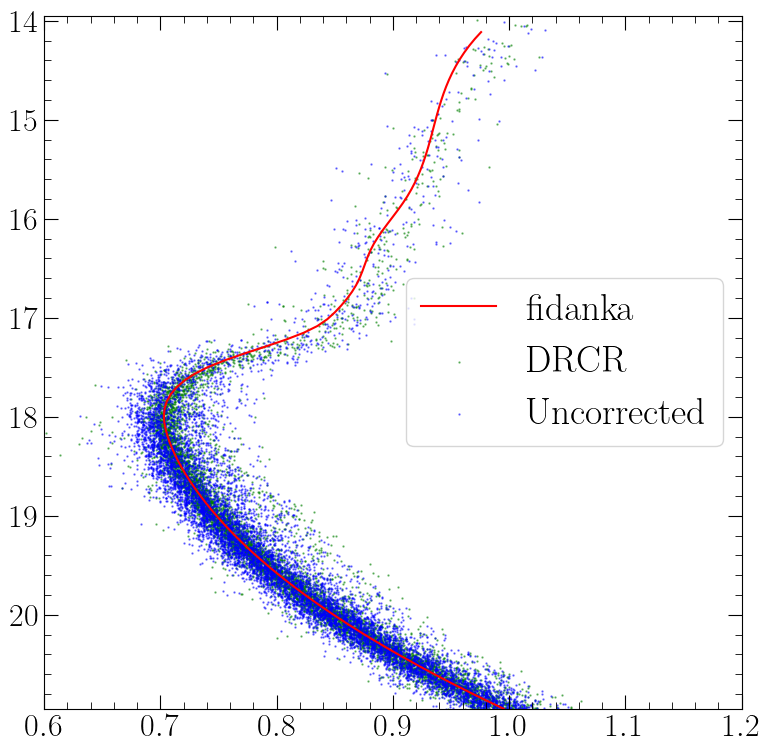

In [30]:
V_MSTO = 18.3
VI_MSTO = 0.70
V_SGB = 17.45
VI_SGB = 0.75
plt.plot(fidanka['vi'],fidanka['v'],c='r',label='fidanka')
plt.scatter(obs_CR[0] ,obs_CR[1],s=0.5,alpha=0.5,c='g',label='DRCR')
plt.scatter(df['vi'],df['v'],s=0.5,alpha=0.5,c='b',label='Uncorrected')
plt.legend()
plt.ylim(V_SGB+3.5,V_SGB-3.5)
plt.xlim(0.6,1.2);

In [31]:
data = {'v':obs_CR[1], 'vi':obs_CR[0]}
fitstars_DRCR = pd.DataFrame(data=data)
fitstars_DRCR.to_csv("{}_fitstars_DRCR.dat".format(GC_name),index=False)

In [32]:
fitstars_DRCR_2dKS = fitstars_DRCR[(fitstars_DRCR['v'] < V_SGB + 2) & (fitstars_DRCR['v'] > V_SGB - 2)]
fitstars_DRCR_2dKS.to_csv("{}_fitstars_2dKS_DRCR.dat".format(GC_name),index=False)